# Read dataset

The dataset is available inside the keras module of the tensorflow labrary. We just call the load data function and the dataset is returned. However as can be seen in the plot the values are not normalized.

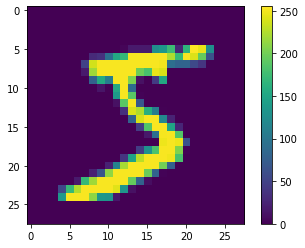

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
image = plt.imshow(x_train[0])
plt.colorbar(image)

In order to normalize we just take the input images from both the training dataset and testing dataset and devide them by 255. The images are encoded as 8 bit greyscale images so in order to bound the values between 0 and 1 we just need to divide by 255.

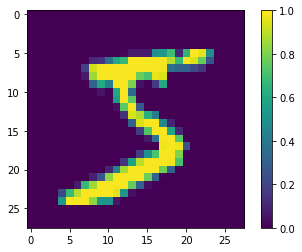

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0
image = plt.imshow(x_train[0])
plt.colorbar(image)

# Model

The model is not the focus of the experiments, for this reason a realy simple model is used. The model only has single hidden layer with 128 units. As output softmax is chosen because we want the output to be a probability distribution.

We use Adam as an optimizer and sparse categorical crossentropy as our loss function.

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [5]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4299 - accuracy: 0.8800 - val_loss: 0.1393 - val_accuracy: 0.9587
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1236 - accuracy: 0.9641 - val_loss: 0.0980 - val_accuracy: 0.9706
Epoch 3/5
1875/1875 [==============================] - 2s 1000us/step - loss: 0.0805 - accuracy: 0.9765 - val_loss: 0.0909 - val_accuracy: 0.9713
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0568 - accuracy: 0.9834 - val_loss: 0.0772 - val_accuracy: 0.9766
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0421 - accuracy: 0.9871 - val_loss: 0.0817 - val_accuracy: 0.9748


# Importance metric

Once the network is trained with the training dataset we can calculate our metric based on the weights of the trained network. It is important to note that the importance of each individual pixel can change depending on the particular execution but the same patterns should repeat. For example in our case the pixels on the corners of the image can be ignored because they have a very low importance.

(784, 128)


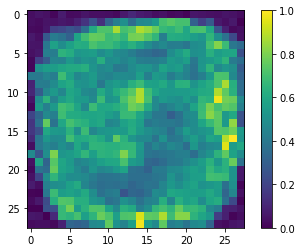

In [6]:
import numpy as np
first_layer_weights = model.get_weights()[0]
print(first_layer_weights.shape)
mean_weights = np.mean(np.abs(first_layer_weights), axis=1)
importance = (mean_weights - np.min(mean_weights)) / (np.max(mean_weights) - np.min(mean_weights))
importance_image = np.reshape(importance, (28, 28))
image = plt.imshow(importance_image)
plt.colorbar(image)

After we have generated the metric we can use it to generate masks based on the a set threshold. The masks generated are the following.


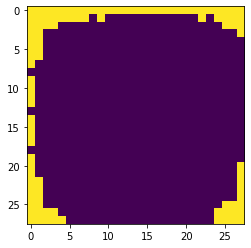

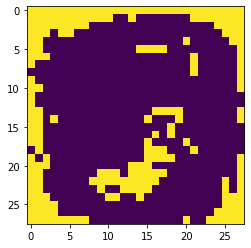

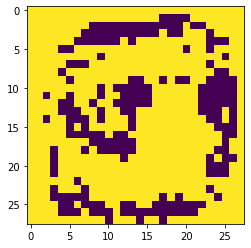

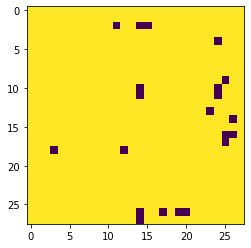

In [9]:
masks = []
for index, threshold in enumerate([20, 40, 60, 80]):
    mask = np.zeros((28, 28), dtype='int32')
    mask[importance_image < (threshold / 100)] = 1
    plt.imshow(mask)
    plt.show()
    masks.append(mask)

In [10]:
evals = []
for mask, threshold in zip(masks, [20, 40, 60, 80]):
    new_xtrain = x_train[:, mask]
    new_xtest = x_test[:, mask]
    mask_eval = {'threshold': threshold, 'mask_count': sum(mask)}
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=new_xtrain.shape[1:]),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(new_xtrain, y_train, validation_data=(new_xtest, y_test), epochs=5)
    mask_eval.update(model.evaluate(new_xtest, y_test, return_dict=True))
    evals.append(mask_eval)

Epoch 1/5


ValueError: in user code:

    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\losses.py:1568 sparse_categorical_crossentropy
        return K.sparse_categorical_crossentropy(
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\backend.py:4940 sparse_categorical_crossentropy
        res = nn.sparse_softmax_cross_entropy_with_logits_v2(
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\ops\nn_ops.py:4240 sparse_softmax_cross_entropy_with_logits_v2
        return sparse_softmax_cross_entropy_with_logits(
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\ops\nn_ops.py:4153 sparse_softmax_cross_entropy_with_logits
        raise ValueError("Shape mismatch: The shape of labels (received %s) "

    ValueError: Shape mismatch: The shape of labels (received (32,)) should equal the shape of logits except for the last dimension (received (25088, 10)).


In [ ]:
import pandas as pd
print(pd.DataFrame(evals))